## Importing and setup

In [ ]:
!pip install ohmeow-blurr

In [ ]:
!unzip '/content/drive/MyDrive/train.csv.zip'

Archive:  /content/drive/MyDrive/train.csv.zip
  inflating: train.csv               


In [ ]:
import torch
from transformers import *
from fastai.text.all import *

from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Defining task, model, arch, config and tokenizer

In [ ]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "bert-base-uncased"

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,  task=task, config_kwargs={'num_labels': 3})

In [ ]:
model_path = Path('models')

## Reading dataset into Pandas dataframe

In [ ]:
#Read dataset
df = pd.read_csv('/content/train.csv')

In [ ]:
#Check size
df.shape

(146811, 3)

## Pre-processing

In [ ]:
#Drop review_id column
df = df.drop(['review_id'], axis=1)

In [ ]:
#Change review column to lowercase
df['review'] = df['review'].str.lower()

In [ ]:
#Drop duplicate rows
df = df.drop_duplicates()

In [ ]:
#Check shape again
df.shape

(116697, 2)

In [ ]:
#Shuffle rows
df = df.sample(frac=1).reset_index(drop=True)

### Adding a new column with sentiment based on rating

In [ ]:
def scoretosent(score):
  if score > 3:
    return "positive"
  elif score == 3:
    return "neutral"
  else:
    return "negative"

In [ ]:
df["sentiment"] = df["rating"].apply(lambda score: scoretosent(score))

In [ ]:
df

,review,rating,sentiment
0,pleasant transportation is very slow,2,negative
1,"like similar products, madam gie price'm bangettt sukaaaa dehhhhhh ......... @@ 85 (5 (6 (6) 6) 6) 6) 6) 8) 8) 8 (8 (",4,positive
2,look like no original product.,1,negative
3,"according to the statement, has a gift of balloons with beautiful colors, good product quality. transport service, fast delivery, good package to arrive, then the damage.",4,positive
4,"defective products factory these blocks trolley order 2pcs, 1pc without wheels. sya order another store, product distinguished sm, a wheel g jg, pnjualnya admit dr factory defect. mgkn same reply. dr disabled pbrik lazy returns, because loss of postage, send a 2kg weight pjuat morbidly conscientious, send brg disabilities. krna tau mls buyer returns, loss sis",1,negative
...,...,...,...
116692,size 3 / 4nya stands,3,neutral
116693,"goods okay, but smpi² dh box all dented, brg very slow mandailing, mandailing trpaksa pushes himself, but not one seller.",3,neutral
116694,thank shop for lixi infant. wish shop is always expensive restaurant. increasingly crowded,5,positive
116695,good quality .. she wanted him all i ordered it in shop..delivered 1 day before my expected date of delivery. thank you.,5,positive


### Creating data bunch from dataset

In [ ]:
# Define block type
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
 
#Create datablock object
dblock = DataBlock(blocks=blocks,  get_x=ColReader('review'), get_y=ColReader('sentiment'), splitter=TrainTestSplitter())

In [ ]:
########### SLOW ############
#Create data loader
dls = dblock.dataloaders(df, bs=32)

In [ ]:
#Save dataloader
torch.save(dls, '/content/drive/MyDrive/dataloader3.pkl')

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,category
0,"commodity normal, but the logistics can provide a range of services and sellers of cognitive poles apart, the logistics can the seller to confirm delivery to the latest six, so i marked at five thirty receipt sellers also agree, but the logistics for the day at noon to play for delivery they just can not say half past five delivery to three, and only three with twelve receipt, other times he was very busy, if not directly with the return back to the seller, or i have to go deliveryman pickup on delivery routes. since this point in time need this product so i spent a single train journey from the company over forty minutes to the shipping address on the order does not agree with a way of logistics and time.......... originally order to save time and deliver to the government was wasting my selection racquet more time, energy and oil money. 20, 191, 221, faithfully reflecting the actual purchasing situation believe the seller to provide logistics error message wasted time and money to the two stars, but the seller was evaluated two weeks, so the evaluation is to modify a star",negative
1,"this stuff generally poor quality of the store, bought four products, each has a problem, there are obvious stains inflatable chair, completely come off ; fisher rainbow circle sets burrs will scratch hands ; there are rattles heavy musty. only more than rattle return, because it might affect child health, not for the children to play, but still without success, he said, has opened other reasons, but not unpack how serious musty find? in short, is the blacklist! can give a negative assessment, but should not be intimidating tone came full of messages, you really have to be careful!",negative


In [ ]:
#Define model
model = HF_BaseModelWrapper(hf_model)

In [ ]:
#Define learner object
learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

In [ ]:
learn.create_opt() 

#Freeze layers
learn.freeze()

In [ ]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

0.00363078054770101


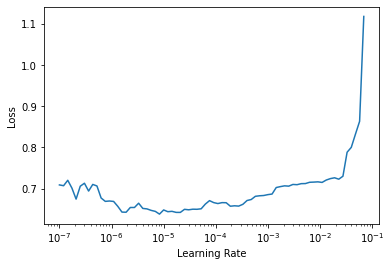

In [ ]:
print(find_appropriate_lr(learn))

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.675701,0.676843,0.710883,11:28


0.004365158322401656


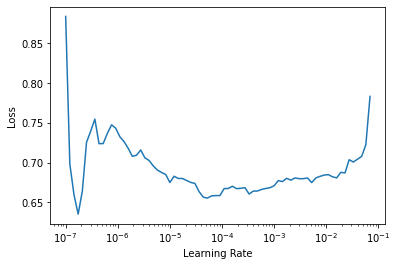

In [ ]:
#Get appropriate learning rate again
print(find_appropriate_lr(learn))

In [ ]:
learn.save('/content/drive/MyDrive/NLP_model4.pkl')

Path('/content/drive/MyDrive/NLP_model4.pkl.pth')

In [ ]:
#Unfreeze all layers for training
learn.unfreeze()

In [ ]:
#Train again
learn.fit_one_cycle(7, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.683308,0.669959,0.714439,17:20
1,0.672856,0.652645,0.724250,17:17
2,0.662773,0.639496,0.728149,17:17
3,0.672994,0.632960,0.731705,17:15
4,0.623852,0.629860,0.733376,17:17


Buffered data was truncated after reaching the output size limit.

In [ ]:
learn.save('/content/drive/MyDrive/NLP_model4-1.pkl')

## Result

In [ ]:
#Get some predicitons
learn.show_results(learner=learn, dl=dls.valid, max_n=2)

,text,category,target
0,"even if it's sent from abroad, a very good compared to the price. color meets shape i recommend this restaurant to me. i'm like, see good good good good good good good good good good good escorts inspiration and a preceding preceding a preceding great inspiration and great great great great great great inspiration and great great great great just great inspiration good good good good good good ea escorts escorts triggering single well. good good good good good good good inspiration good good good good good just a great inspiration and great great great great great great great inspiration and great great great great great great great great great great inspiration and a great inspiration and a great escorts escorts great great inspiration and great. great inspiration and great great great great inspiration and great daii good escorts inspiration and a great inspiration and great great great great great great inspiration and a great inspiration and great great great great great inspiration good just good good good good good good good good good good good good good good. good good good good good good good good good good phuket, phuket, phuket, good good good good good good good good good good good good good good good good inspiration.",neutral,positive
1,"the boss service attitude of tolerance, i ordered february 20, asked a few numbers can ship, ship owners answer no. 23 uniform, i wait until february 28 japanese goods have not been to, ask the boss learned that only 26 shipments, i would stick with him the last time chats, not the no. 23 uniform ship it? he answer is no. 23 in accordance with a unified single ship, of course, as a consumer, i would say that i knew to complain about so late shipments, i don't buy, but also to inform the boss will not get the goods after the evaluation to be too high, the boss even domineering back to say not wait to cancel the order, i always emphasize that i don't return, and other goods to the boss even unauthorized interception of goods, i want to cancel the order, or can not get the goods, not money back, my whole dumbfounded, helpless next only to cancel the order, so service quality is not, totally does not allow customers complain! because only entrained 6 photos, so the chat is not very complete. above is entirely my personal feelings if i have offended, vexed.",negative,negative


In [ ]:
#Save the model
learn.save('/content/drive/MyDrive/NLP_model4.pkl')

Path('/content/drive/MyDrive/NLP_model2.pkl.pth')

In [ ]:
#Get predicitions for validation set
preds = learn.get_preds(ds_idx=1, with_decoded=True, act=None)

In [ ]:
#Turn tensor into a list of ints
y_preds = list(map(int, preds[1]))
y_true = list(map(int, preds[2]))

In [ ]:
predsNonDF[0]

tensor([[0.0044, 0.1044, 0.8912],
        [0.0037, 0.0419, 0.9544],
        [0.0013, 0.0204, 0.9783],
        ...,
        [0.0332, 0.2414, 0.7254],
        [0.6797, 0.2660, 0.0543],
        [0.1645, 0.1879, 0.6476]])

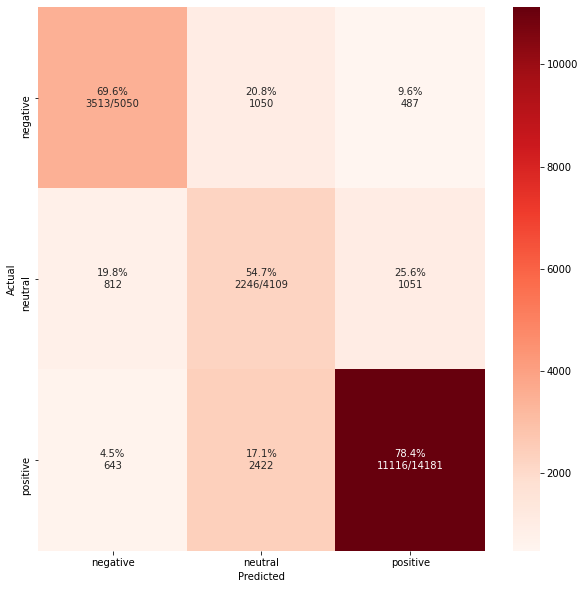

In [ ]:
#Plotting consufion matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, xticklabels=['negative','neutral','positive'], yticklabels=['negative','neutral','positive'], cmap= "Reds", annot=annot, fmt='', ax=ax)
    
plot_cm(y_true, y_preds)

### Some Examples

In [ ]:
learn.blurr_predict("I didn't like the product. Cheap quality")

[(('negative',), (#1) [tensor(0)], (#1) [tensor([0.8438, 0.1140, 0.0422])])]

In [ ]:
learn.blurr_predict("Cheap price. Fast delivery")

[(('positive',), (#1) [tensor(2)], (#1) [tensor([0.0152, 0.1328, 0.8519])])]

In [ ]:
learn.blurr_predict("Seems so-so")

[(('neutral',), (#1) [tensor(1)], (#1) [tensor([0.2097, 0.4344, 0.3559])])]

In [ ]:
learn.blurr_predict("Feels cheap")

[(('negative',), (#1) [tensor(0)], (#1) [tensor([0.3620, 0.2779, 0.3601])])]

## Scrape Shopee reviews

In [ ]:
#Reference: https://stackoverflow.com/a/62485956/8061030
import re
import json
import requests

url = 'https://shopee.com.my/Xiaomi-Redmi-9-(3GB-32GB)-Global-Version-1-Year-Local-Official-Warranty--i.139641550.5936664098'

r = re.search(r'i\.(\d+)\.(\d+)', url)
shop_id, item_id = r[1], r[2]
ratings_url = 'https://shopee.co.id/api/v2/item/get_ratings?filter=0&flag=1&itemid={item_id}&limit=20&offset={offset}&shopid={shop_id}&type=0'

offset = 0

scraped_df = pd.DataFrame(columns=['review', 'rating'])

while True:

    data = requests.get(ratings_url.format(shop_id=shop_id, item_id=item_id, offset=offset)).json()

    i = 1
    for i, rating in enumerate(data['data']['ratings'], 1):
        # print(rating['author_username'])
        scraped_df.loc[len(scraped_df)] = [rating['comment'], rating['rating_star']]
        # print('-' * 80)

    if i % 20:
        break

    offset += 20

In [ ]:
scraped_df["sentiment"] = scraped_df["rating"].apply(lambda score: scoretosent(score))

In [ ]:
scraped_df

,review,rating,sentiment
0,"Seminggu je da sampai fuhhh terbaikla seller n courier masheeeh memang nak guna urgent lepas hp rosak nak2 ade online classes ni. Tepat2 sampai semalam. Korang jangan risau, telefon ni 100% authentic. Parcel takde rosak langsung, takde calar pun fresh bethol rasa macam beli f2f dengan tauke kedai❤",5,positive
1,Good good good good good good Good good good good good good Good good good good good good Good good good good good good Good good good good good good Good good good good good good Good good good good good good Good good good good good good Good good good good good good Good good good good good good,5,positive
2,Barang sampai cepat dan kemas. Barang tiada yang defect.....Quality pun sangat baik....\npada harga yang sangatlah berpatutan jika dibandingkan dengan kedai-kedai lain yang menjualnya.....\nGood product quality\nGood Value for money\nFast delivery \nExcellent service by sellerr,5,positive
3,Good product quality\nGood value for money\nVery very very fast delivery\nExcellent service by seller\nShipping take 5days only from china..very very impressive\n👍🏻👍🏻👍🏻👍🏻👍🏻,5,positive
4,Walaoo daebak 💓💓 took a week only to reach here kudos to seller. Hope it working well. Video and picture not related but phone is good received 💅,5,positive
...,...,...,...
950,Okay good product...........Okay good product...........Okay good product...........,5,positive
951,Im satisfy with this shop. The delivery quite fast ha. I have used it about 2 weeks?? And it is the best choice i ever made👍🏻👍🏻👍🏻👍🏻,5,positive
952,Terbaik terbaik terbaik terbaik terbaik terbaik terbaik..,5,positive
953,Everything is good... Everything is good... Everything is good... Everything is good... Everything is good... Everything is good... Everything is good... Everything is good... Everything is good... Everything is good... Everything is good... Everything is good... \n👍🏻👍🏻👍🏻👍🏻👍🏻👍🏻👍🏻👍🏻👍,5,positive


In [ ]:
#Shuffle rows
scraped_df = scraped_df.sample(frac=1).reset_index(drop=True)

In [ ]:
#Show predicitons
learnv3.show_results(learner=learn, dl=dls.test_dl(scraped_df, with_labels=True), max_n=10, trunc_at=100)

,text,category,target
0,"phone da sampai semalam, not bad cepat jugak seminggu dah sampai. cek semua complete dan dalam keada",positive,positive
1,alhamdulillah subhanallah maha suci allah alhamdulillah subhanallah maha suci allah alhamdulillah su,positive,positive
2,alhamdulilah. pakej smpi di kk dalam masa 11 hari shj. cepat dlm tempoh pkpp ni. fon original & dite,positive,positive
3,terimah kaseh tapi lambat terimah kaseh tapi lambat terimah kaseh tapi lambat terimah kaseh tapi lam,positive,positive
4,"order pada 19 / 06 / 2020, terima pada 29 / 06 / 2020. boleh tahan laju walaupun dari china. terima",positive,positive
5,brg da sampai!!! penghantaran sangat cepat even dri luar negara... everything ok.... fon nice gila!!,positive,positive
6,good good good good good good good good good good good good good good good good good good good good,positive,positive
7,"dah sampai kira ok la oversea tak ada la lama sangat, apa2 pun puas hati... dah sampai kira ok la ov",positive,positive
8,terbaik penghantaran daripada china.. sampai jugak terbaik sampai... terbaik penghantaran daripada c,positive,neutral
9,took 9 days to arrive from china. phone is superb for the price. definitely worth it to pay a bit mo,positive,positive


In [ ]:
scraped_df.to_csv('/content/drive/MyDrive/scraped_reviews.csv')

In [ ]:
scraped_df = pd.read_csv('/content/drive/MyDrive/scraped_reviews.csv')

## Testing the models

In [ ]:
#Load the first dataloader
with open('/content/drive/MyDrive/dataloader.pkl', 'rb') as f: 
  dlsv1 = torch.load(f)

In [ ]:
#Load the first model
learnv1 = learn.load(file='/content/drive/MyDrive/NLP_model.pkl')

In [ ]:
learn.validate(ds_idx=0)

(#2) [0.5403690338134766,0.7740293145179749]

In [ ]:
learnv1.validate(ds_idx=1)

(#2) [0.5535681247711182,0.7685182094573975]

In [ ]:
learnv1 = learn

In [ ]:
#Load the second dataloader
with open('/content/drive/MyDrive/dataloader2.pkl', 'rb') as f: 
  dlsv2 = torch.load(f)

In [ ]:
#Define second learner object
learnv2 = Learner(dlsv2, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

In [ ]:
#Load model
learnv2 = learnv2.load(file='/content/drive/MyDrive/NLP_model2.pkl')

In [ ]:
learnv2.validate(ds_idx=0)

(#2) [0.637085497379303,0.7293238043785095]

In [ ]:
learnv2.validate(ds_idx=1)

(#2) [0.6553114056587219,0.7230077385902405]

In [ ]:
#Load third dataloader
with open('/content/drive/MyDrive/dataloader3.pkl', 'rb') as f: 
  dlsv3 = torch.load(f)

In [ ]:
#Define third learner object
learnv3 = Learner(dlsv3, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

In [ ]:
#Load model
learnv3 = learnv3.load(file='/content/drive/MyDrive/NLP_model4-1.pkl')

In [ ]:
learnv3.validate(ds_idx=0)

(#2) [0.6030001640319824,0.7461754083633423]

In [ ]:
learnv3.validate(ds_idx=1)

(#2) [0.6274069547653198,0.7343615889549255]